In [89]:
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, Dense, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.layers import GRU
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, f1_score, accuracy_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [36]:


drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset.tsv', sep='\t')
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(99999, 2)

In [37]:
df.head(10)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
5,Positive,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...
6,Positive,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
8,Positive,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...


In [38]:
df.iloc[70000:70010]

,label,text
70000,Negative,السجينة،،تعجبني جدا الروايات المقتبسة من قصص و...
70001,Negative,كفايه عليها نجمه واحده بقى. النجمه بتوفى بممكن...
70002,Negative,الحاجه اللى تضايق ان الرواية كانت ممكن تكون اف...
70003,Negative,الحمد لله رب العالمين. تلك الأيام وفتحى غانم ا...
70004,Negative,كتاب خفبف و مسلى و يتقرأ فى ساعه
70005,Negative,اسلوب احلام جميل كالعاده برومانسيتها وتصويرها ...
70006,Negative,قراتى للكتاب مجرد فضول منى وقولت اضحك شوية تغي...
70007,Negative,أفتقدت نزار في هذا الديوان
70008,Negative,بكره أحمد مراد
70009,Negative,هذه الرواية جميلة في اسلوبها تتنقل بين الغزل ا...


In [39]:



# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']

    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)

    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)

    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    #trim
    text = text.strip()

    return text

In [40]:


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
df['sentence_embedding'] = df['text'].apply(clean_str)

In [42]:
df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   label               99999 non-null  object
 1   text                99999 non-null  object
 2   sentence_embedding  99999 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [43]:
df.head(10)

,label,text,sentence_embedding
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,ممتاز نوعا ما النظافه والموقع والتجهيز والشاط...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,احد اسباب نجاح الامارات ان كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,هادفه وقويه تنقلك من صخب شوارع القاهره الي هد...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,خلصنا مبدئيا اللي مستني ابهار زي الفيل الازرق...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,ياسات جلوريا جزء لا يتجزا من دبي فندق متكامل ...
5,Positive,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...,اسلوب الكاتب رائع جدا وعميق جدا قراته عده مرات...
6,Positive,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...,استثنائي الهدوء في الجناح مع مسبح عدم وجود عاز...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...,الكتاب هو السيره الذاتيه للحداثه في المملكه بل...
8,Positive,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..,من اجمل ما قرات روايه تستحق القراءه فعلا
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...,بشكل عام جيده التجاوب جيد جدا من قبل موظفي ا...


In [44]:
df['label_id'] = df['label'].map({'Negative': 0, 'Positive': 1 , 'Mixed': 2})

In [45]:
df.head()

,label,text,sentence_embedding,label_id
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,ممتاز نوعا ما النظافه والموقع والتجهيز والشاط...,1
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,احد اسباب نجاح الامارات ان كل شخص في هذه الدول...,1
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,هادفه وقويه تنقلك من صخب شوارع القاهره الي هد...,1
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,خلصنا مبدئيا اللي مستني ابهار زي الفيل الازرق...,1
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,ياسات جلوريا جزء لا يتجزا من دبي فندق متكامل ...,1


In [46]:

X_train, X_test, y_train, y_test = train_test_split(df['sentence_embedding'], df['label_id'], test_size=0.1, stratify=df['label_id'], random_state=42)

In [47]:
#y_train_encoded = to_categorical(y_train, num_classes=3)
#y_test_encoded = to_categorical(y_test, num_classes=3)

#y_train_encoded.shape , y_test_encoded.shape

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [49]:
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_test = tokenizer.texts_to_sequences(X_test)

In [50]:
print(encoded_train[0])

[92, 141, 11854, 2, 540]


In [51]:
max_length = 30
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(padded_train)
padded_train.shape , padded_test.shape

[[    92    141  11854 ...      0      0      0]
 [  3425      1   1262 ... 122847     18   5052]
 [  3628     73   3363 ...      0      0      0]
 ...
 [   157   5538    191 ...      0      0      0]
 [    32    934     11 ...    458    996   2410]
 [ 13448  11136    681 ...      0      0      0]]


((89999, 30), (10000, 30))

In [70]:
vocab_size = len(tokenizer.word_index) + 1

In [71]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(LSTM(16, return_sequences=False, activation='tanh'))
model.add(Dense(3, activation='softmax'))

In [72]:
custom_optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [73]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 10)            2695820   
                                                                 
 lstm_2 (LSTM)               (None, 16)                1728      
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2697599 (10.29 MB)
Trainable params: 2697599 (10.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [74]:
history=model.fit(x=padded_train, y=y_train, epochs=100, validation_data=(padded_test, y_test), verbose=1, batch_size=512,
          callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

Epoch 1/100
176/176 [==============================] - 21s 104ms/step - loss: 1.0967 - accuracy: 0.3559 - val_loss: 1.0903 - val_accuracy: 0.3710
Epoch 2/100
176/176 [==============================] - 13s 73ms/step - loss: 0.9430 - accuracy: 0.5147 - val_loss: 0.8739 - val_accuracy: 0.5659
Epoch 3/100
176/176 [==============================] - 7s 39ms/step - loss: 0.8205 - accuracy: 0.6084 - val_loss: 0.8371 - val_accuracy: 0.5883
Epoch 4/100
176/176 [==============================] - 7s 42ms/step - loss: 0.7542 - accuracy: 0.6573 - val_loss: 0.8423 - val_accuracy: 0.5939
Epoch 5/100
176/176 [==============================] - 5s 27ms/step - loss: 0.6990 - accuracy: 0.6957 - val_loss: 0.8864 - val_accuracy: 0.5925
Epoch 6/100
176/176 [==============================] - 4s 22ms/step - loss: 0.6459 - accuracy: 0.7312 - val_loss: 0.8813 - val_accuracy: 0.6010
Epoch 7/100
176/176 [==============================] - 4s 25ms/step - loss: 0.5803 - accuracy: 0.7674 - val_loss: 0.9150 - val_accura

In [75]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

313/313 [==============================] - 1s 2ms/step


In [76]:
predicted_labels = np.argmax(preds, axis=1)

print(predicted_labels)

[0 0 2 ... 2 0 1]


In [77]:
# Generate the classification report
report = classification_report(y_test, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      3333
           1       0.69      0.60      0.64      3333
           2       0.52      0.55      0.54      3334

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



In [79]:
examples=["المنتج رائع وجودة عالية. أنصح به للجميع.","سيئة جداً، لا يستحق السعر الذي دفعته.","الجودة جيدة، ولكن السعر مرتفع بعض الشيء."]

In [80]:
cleaned_examples = [clean_str(example) for example in examples]

encoded_examples = tokenizer.texts_to_sequences(cleaned_examples)

padded_examples = pad_sequences(encoded_examples, maxlen=max_length, padding='post')

In [81]:
pred = (model.predict(padded_examples) > 0.5).astype("int32")
print(pred)

1/1 [==============================] - 0s 21ms/step
[[0 1 0]
 [1 0 0]
 [0 0 1]]


In [82]:
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2206  262  865]
 [ 486 2016  831]
 [ 845  643 1846]]


In [87]:
def get_accuracy(name, history, x_train, y_train, x_test, y_test):
    # Extract training and validation loss from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the train and test loss curves
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='test')
    plt.legend()
    plt.show()

    # Make predictions and convert to labels
    tree_predict = history.model.predict(x_test)
    predicted_labels = np.argmax(tree_predict, axis=1)

    # Show the classification report
    report = classification_report(y_test, predicted_labels)
    print("Classification Report:")
    print(report)

    # Show the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(name + ' Confusion Matrix')
    plt.show()

    print("Classification Report (Training Set):")
    print(classification_report(y_train, np.argmax(history.model.predict(x_train), axis=1)))
    print("Classification Report (Test Set):")
    print(report)


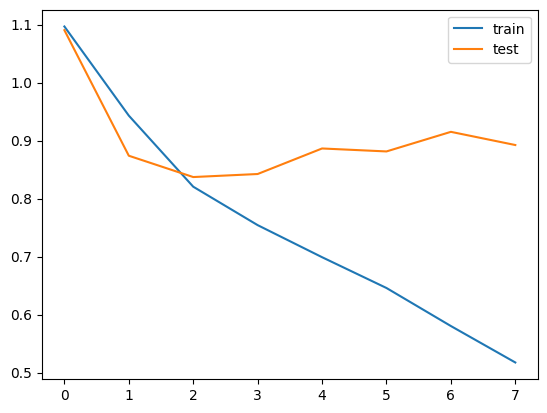

313/313 [==============================] - 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3333
           1       0.67      0.63      0.65      3333
           2       0.50      0.61      0.55      3334

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000



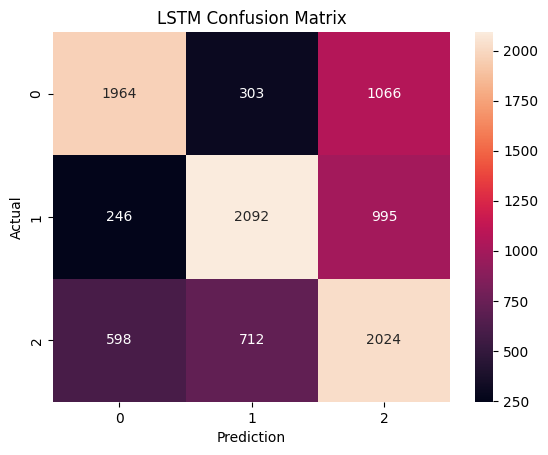

Classification Report (Training Set):
2813/2813 [==============================] - 7s 3ms/step
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     30000
           1       0.90      0.87      0.89     30000
           2       0.75      0.86      0.80     29999

    accuracy                           0.85     89999
   macro avg       0.85      0.85      0.85     89999
weighted avg       0.85      0.85      0.85     89999

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3333
           1       0.67      0.63      0.65      3333
           2       0.50      0.61      0.55      3334

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000



In [88]:
get_accuracy('LSTM',history,padded_train, y_train, padded_test, y_test)